#### Load documents with IDs

In [3]:
import requests

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [5]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

#### Load ground truth

In [6]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [7]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [8]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

#### Index data

In [9]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

In [10]:
!docker run \
    --rm \
    --name elasticsearch \
    -d \
    -p 9200:9200 \
    -p 9300:9300 \
    -e "discovery.type=single-node" \
    -e "xpack.security.enabled=false" \
    docker.elastic.co/elasticsearch/elasticsearch:8.4.3

9c824f29f2ebb2d23fef4113194f8baa9348bf310284887c579317dd5de4545d


In [11]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [12]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

#### Retrieval

In [13]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [14]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

#### The RAG flow

In [15]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [16]:
from openai import OpenAI

client = OpenAI()

def llm(prompt, model='gpt-4o'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [17]:
# previously: rag(query: str) -> str
def rag(query: dict, model='gpt-4o') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [18]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [19]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

#### Cosine similarity metric

In [20]:
answer_orig = 'Yes, sessions are recorded if you miss one. Everything is recorded, allowing you to catch up on any missed content. Additionally, you can ask questions in advance for office hours and have them addressed during the live stream. You can also ask questions in Slack.'
answer_llm = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.7591172

In [21]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [22]:
len(ground_truth)

1830

In [23]:
answers = {}

In [24]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

  0%|          | 0/1830 [00:00<?, ?it/s]

In [25]:
len(answers)

1830

In [26]:
answers

{0: {'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/), scrolling down, and starting to go through the course materials. Additionally, you can access the course syllabus directly through this link: [http://mlzoomcamp.com/#syllabus](http://mlzoomcamp.com/#syllabus).',
  'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
  'document': '0227b872',
  'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp'},
 1: {'answer_llm': 'Sure! You can sign up for the course using the following link: [Sign Up](https://airtable.c

In [27]:
answers.values()

dict_values([{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/), scrolling down, and starting to go through the course materials. Additionally, you can access the course syllabus directly through this link: [http://mlzoomcamp.com/#syllabus](http://mlzoomcamp.com/#syllabus).', 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork', 'document': '0227b872', 'question': 'Where can I sign up for the course?', 'course': 'machine-learning-zoomcamp'}, {'answer_llm': 'Sure! You can sign up for the course using the following link: [Sign Up](https://airtable.com/

In [28]:
results_gpt4o = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4o[i] = val.copy()
    results_gpt4o[i].update(ground_truth[i])

In [29]:
import pandas as pd

In [30]:
df_gpt4o = pd.DataFrame(results_gpt4o)

In [31]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
df_gpt4o.to_csv('data/results-gpt4o.csv', index=False)

In [33]:
!head data/results-gpt4o.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
"You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/), scrolling down, and starting to go through the course materials. Additionally, you can access the course syllabus directly through this link: [http://mlzoomcamp.com/#syllabus](http://mlzoomcamp.com/#syllabus).","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
Sure! You can sign up for the course using the following link: [Sign Up](https://airtable.com/shryxwLd0COOEaqXo).,"Machine Learning Zoomcamp FAQ
The purpose

#### Evaluating GPT 3.5

In [34]:
rag(ground_truth[10], model='gpt-3.5-turbo')

"No, sessions are recorded so you won't miss anything."

In [35]:
from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [36]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [37]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded so if you miss one, you can still watch it later.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

In [ ]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [40]:
!head data/results-gpt35.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this 

### Cosine similarity

* A->Q->A' cosine similarity

* A -> Q -> A'

* cosine(A, A')

#### gpt-4o

In [41]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [43]:
results_gpt4o[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/), scrolling down, and starting to go through the course materials. Additionally, you can access the course syllabus directly through this link: [http://mlzoomcamp.com/#syllabus](http://mlzoomcamp.com/#syllabus).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [42]:
record = results_gpt4o[0]

In [44]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [45]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [46]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679514
std         0.216859
min        -0.180581
25%         0.588410
50%         0.738235
75%         0.835745
max         0.992083
Name: cosine, dtype: float64

In [47]:
import seaborn as sns

/tmp/ipykernel_66923/2967343473.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

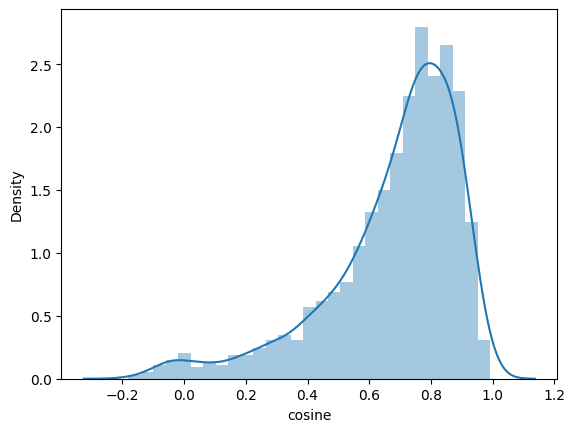

In [49]:
sns.distplot(df_gpt4o['cosine'])

#### gpt-3.5-turbo

In [51]:
df_gpt35 = pd.read_csv('data/results-gpt35.csv')

In [52]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [53]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [55]:
import matplotlib.pyplot as plt

/tmp/ipykernel_66923/2626235184.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_66923/2626235184.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='3.5')


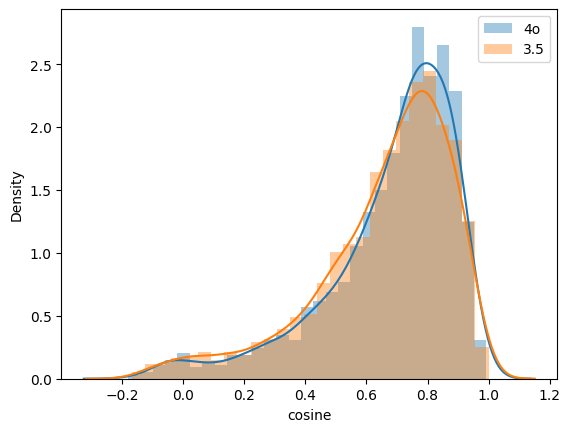

In [58]:
sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt35['cosine'], label='3.5')

plt.legend()

#### gpt-4o-mini

In [59]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [60]:
process_record_4o_mini(ground_truth[10])

{'answer_llm': "Yes, sessions are recorded, so if you miss one, you won't miss anything. You can also ask questions in advance for office hours, and they will be covered during the live stream.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [61]:
results_gpt4omini = []

In [62]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [64]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [63]:
len(results_gpt4omini), len(ground_truth)

(1830, 1830)

In [65]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [66]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680403
std         0.216678
min        -0.140090
25%         0.586770
50%         0.736120
75%         0.837045
max         0.982701
Name: cosine, dtype: float64

/tmp/ipykernel_66923/4043211035.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
/tmp/ipykernel_66923/4043211035.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')


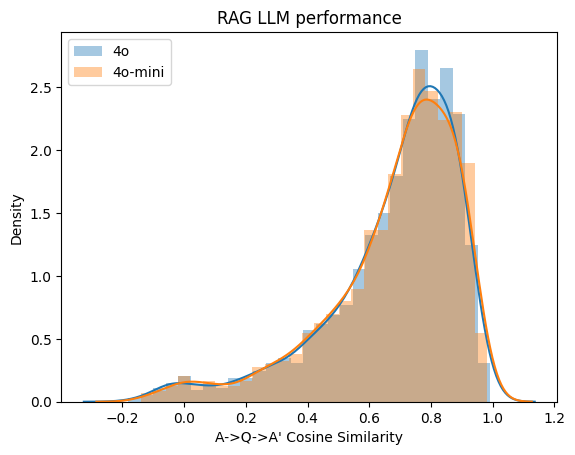

In [67]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

#### LLM-as-a-Judge

In [68]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [70]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [71]:
samples = df_sample.to_dict(orient='records')

In [72]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.901075541973114}

In [73]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [74]:
answer = llm(prompt, model='gpt-4o-mini')

In [75]:
import json

In [76]:
json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer directly addresses the question about the syntax for using precision_recall_fscore_support in Python. It closely matches the original answer, providing the same example and code snippet, thus demonstrating high relevance and similarity.'}

In [77]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [78]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [79]:
df_evaluations = pd.DataFrame(json_evaluations)

In [80]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           125
PARTLY_RELEVANT     16
NON_RELEVANT         9
Name: count, dtype: int64

In [84]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']#.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer addresses a different iss...
11,NON_RELEVANT,The generated answer addresses a different err...
27,NON_RELEVANT,The generated answer does not address the ques...
41,NON_RELEVANT,The original answer discusses the accessibilit...
90,NON_RELEVANT,The generated answer addresses a different que...
93,NON_RELEVANT,The generated answer does not address the ques...
116,NON_RELEVANT,The generated answer discusses the recommendat...
138,NON_RELEVANT,The generated answer addresses a different asp...
139,NON_RELEVANT,The generated answer does not relate to the or...


In [86]:
samples[4]

{'answer_llm': "The pip version error in this week's serverless deep learning section might be caused by a version conflict between the Scikit-Learn used during training and the version being used in the virtual environment. Specifically, if different versions are being utilized (for example, training with version 1.1.1 and running the application with version 0.24.2), it can lead to warnings and potential issues with the model. To resolve this, ensure that the version of Scikit-Learn used in the virtual environment matches the version used for training the model.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://githu

In [87]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What modification was made to the median_house_value target in the homework?
Generated Answer: The modification made to the median_house_value target in the homework was changing it to binary format. This was necessary because median_house_value is a continuous variable, and for calculating the mutual information score, the targets needed to be discrete, represented as either 0 or 1. This change was made to avoid the subjective division of continuous variables into bins if they remained in their original format.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using 

In [88]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the modification made to the median_house_value target by stating that it was changed to binary format. It explains the reason behind this change and its necessity for calculating the mutual information score, which further clarifies the context of the modification. All elements of the answer are pertinent to the question asked."
}


In [89]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [90]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

JSONDecodeError: Expecting ',' delimiter: line 3 column 108 (char 136)

In [91]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    print(f"Evaluating JSON content at index {i}: {str_eval}")
    try:
        json_eval = json.loads(str_eval)
        json_evaluations_2.append(json_eval)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON at index {i}: {e}")

Evaluating JSON content at index 0: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly provides the syntax for using the `precision_recall_fscore_support` function in Python, including an import statement and an example of how to call the function with parameters. This is exactly what was asked in the question."
}
Evaluating JSON content at index 1: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question about modifying scripts to avoid pickle errors when using waitress. It provides a clear solution by suggesting the separation of the custom column transformer class into a different module and explains the reasoning behind this approach, which is pertinent to the issue of pickle errors in the context of using waitress."
}
Evaluating JSON content at index 2: {
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by providing the correct command to launch a container image i

In [92]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [93]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           125
PARTLY_RELEVANT     16
NON_RELEVANT         9
Name: count, dtype: int64

In [94]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
49,NON_RELEVANT,The generated answer directly states that ther...
101,NON_RELEVANT,The generated answer fails to address the cont...


In [95]:
samples[45]

{'answer_llm': "The provided context does not directly answer the question about the commands to start the Docker daemon on Linux. However, you can typically start the Docker daemon on Linux using one of the following commands:\n\n1. `sudo systemctl start docker` — This command is used on systems with systemd.\n2. `sudo service docker start` — This command can be used on systems with service management.\n\nFor more specific instructions or details, you may refer to Docker's official documentation or the FAQ database related to your course.",
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of t

#### Saving all the data

In [96]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

In [97]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)